<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/llama2/Llama3_8b_instruct_qlora_CoT_Fine_Tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Chain-of-Thought Prompting Elicits Reasoning in Large Language Models

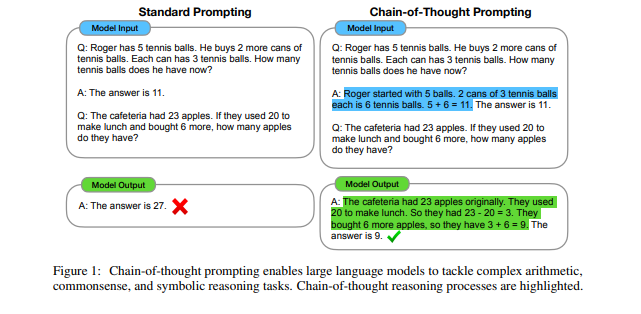

Introduced in Wei et al. (2022), chain-of-thought (CoT) prompting enables complex reasoning capabilities through intermediate reasoning steps. You can combine it with few-shot prompting to get better results on more complex tasks that require reasoning before responding.

Chain-of-Thought Prompting Elicits Reasoning in Large Language Models

https://arxiv.org/abs/2201.11903


https://www.mercity.ai/blog-post/guide-to-chain-of-thought-prompting

https://www.width.ai/post/chain-of-thought-prompting

https://medium.com/@myschang/cot-in-large-language-models-fine-tuning-based-cot-883e39bca107


Zero-shot COT Prompting --> chain of thought
https://arxiv.org/pdf/2205.11916.pdf


The False Promise of Imitating Proprietary LLMs --> https://arxiv.org/pdf/2305.15717.pdf

Orca: Progressive Learning from Complex
Explanation Traces of GPT-4 --> https://arxiv.org/pdf/2306.02707.pdf



Dataset

https://github.com/kaistAI/CoT-Collection/tree/main

paper--> https://arxiv.org/abs/2305.14045





@article{kim2023cot,
  title={The CoT Collection: Improving Zero-shot and Few-shot Learning of Language Models via Chain-of-Thought Fine-Tuning},
  author={Kim, Seungone and Joo, Se June and Kim, Doyoung and Jang, Joel and Ye, Seonghyeon and Shin, Jamin and Seo, Minjoon},
  journal={arXiv preprint arXiv:2305.14045},
  year={2023}
}

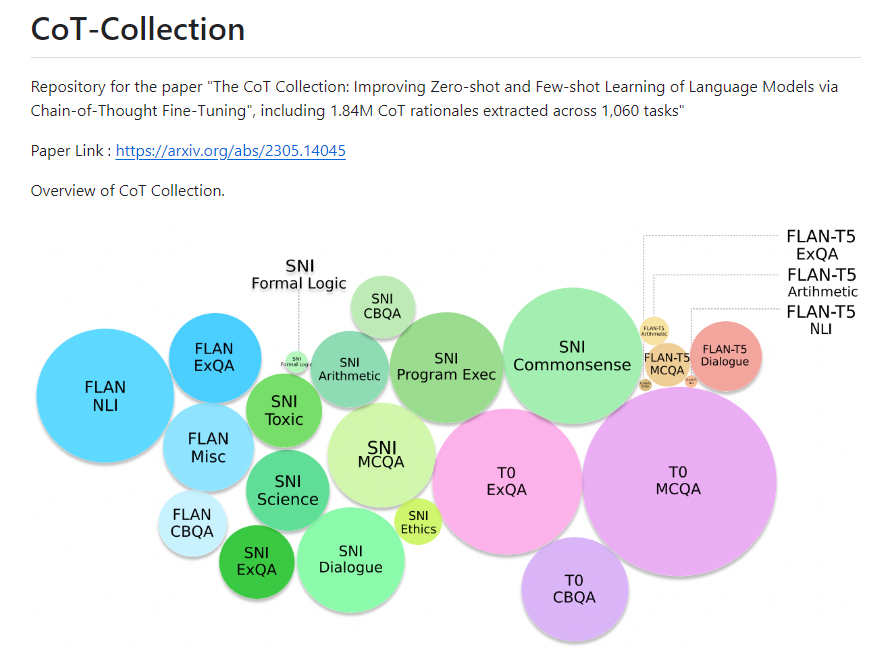

In [ ]:
!pip install torch accelerate bitsandbytes datasets transformers peft trl scipy  wandb -q

#### HuggingFace URI
meta-llama/Meta-Llama-3-8B

In [ ]:
import argparse
import bitsandbytes as bnb
from datasets import load_dataset
from functools import partial
import os
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, AutoPeftModelForCausalLM
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed, Trainer, TrainingArguments, BitsAndBytesConfig, \
    DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset
from torch import cuda, bfloat16
import transformers

import torch
import torch.nn as nn

In [ ]:
transformers.__version__

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()


# Llama3 8B
https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct



In [ ]:
PROJECT = "Llama3-8B-QLora-CoT"
MODEL_NAME = 'meta-llama/Meta-Llama-3-8B-Instruct'
DATASET = "kaist-ai/CoT-Collection"

In [ ]:
from google.colab import userdata
import wandb

wandb_key = userdata.get('WANDB')
wandb.login(key=wandb_key)

In [ ]:
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
device


### nf4 -->  is the normalized float 4 bit data type. It quantizes floats into 4 bits . 4-bit NormalFloat, an information theoretically optimal quantization data type for normally distributed data

### Qlora https://arxiv.org/abs/2305.14314

In [ ]:
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)


model_config = transformers.AutoConfig.from_pretrained(
    MODEL_NAME,
    token=True
)

In [ ]:
model = transformers.AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
    token=True
)
model.eval()
print(f"Model loaded on {device}")

In [ ]:
memory_used = model.get_memory_footprint()
print("Memory footprint: {} ".format(memory_used))

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    MODEL_NAME,
    token=True
)

https://github.com/kaistAI/CoT-Collection/tree/main

In [ ]:
# Load the dataset from Hugging Face
from datasets import load_dataset

dataset = load_dataset("kaist-ai/CoT-Collection", split="train",trust_remote_code=True)

In [ ]:
dataset

In [ ]:
df = dataset.to_pandas()

In [ ]:
df['type'].unique()

In [ ]:
ex= df[0:1].to_dict()
ex['source']

In [ ]:
ex['rationale']

In [ ]:
ex['target']

In [ ]:

print(f'Number of records: {len(df)}')
print(f'Column names are: {list(df.columns)}')

In [ ]:
def create_prompt(rec):

  start = "<INST> <SYS> Read the Instruction below and provide an answer.</SYS>\n"
  question = f"INSTRUCTION:\n{rec['source']}\n"
  response = f"RESPONSE:\n{rec['rationale']}\n"
  answer = f"Therefore the answer is {rec['target']}\n"
  end = "</INST>"

  parts = [part for part in [start, question, response, answer, end] if part]

  formatted_prompt = "\n".join(parts)
  formatted_prompt = formatted_prompt.replace('\\n', '\n')

  rec["text"] = formatted_prompt

  return rec

In [ ]:
p = create_prompt(dataset[35500])
#print(p)
print(p["text"])

In [ ]:
dataset = dataset.map(create_prompt)

In [ ]:
dataset = dataset.map(
        batched=True,
        remove_columns=['source', 'target', 'rationale', 'task', 'type']
    )

In [ ]:
print(dataset[35500]["text"])

In [ ]:
model.config

In [ ]:
#max length of the model
def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length

In [ ]:
mx = get_max_length(model) # 4096 llama2 7B
mx

In [ ]:
len(dataset)

In [ ]:
#tokenize dataset
dataset = dataset.map(lambda samples: tokenizer(samples['text']), batched=True)

In [ ]:
len(dataset)

In [ ]:
dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < mx)

In [ ]:
len(dataset)

In [ ]:
seed = 2
set_seed(seed)

dataset = dataset.shuffle(seed=seed)

In [ ]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [ ]:
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [ ]:
modules = find_all_linear_names(model)
print(modules)

# mistral ['gate_proj', 'o_proj', 'k_proj', 'v_proj', 'down_proj', 'up_proj', 'q_proj']c
# Llama2 ['q_proj', 'o_proj', 'v_proj', 'up_proj', 'gate_proj', 'k_proj', 'down_proj']

### Which Rank and Alpha in Lora
https://medium.com/@fartypantsham/what-rank-r-and-alpha-to-use-in-lora-in-llm-1b4f025fd133


### A brief explanation of QLoRA
LoRA (Low Rank Adaptation) is a way to train a Large Language Model by freezing the model weights, injecting new trainable matrices into the layers and training those matrices. In my examples, I trained roughly 1% of the parameters.

QLoRA (Quantized LoRA) improves this further by allowing the original model to be loaded in a 4-bit quantized manner. This allows a large model to be loaded into a smaller footprint e.g. a 7 billion parameter model could be loaded into a memory footprint of about 3.5 GB ( a back of the envelope calculation would be (7 billion x 4 bits) / (8 bits in a byte) or 7 Billion / 2 to get memory usage in bytes).

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,  #attention heads
    lora_alpha=64,  #alpha scaling
    target_modules=modules ,#['q_proj', 'v_proj', 'k_proj', 'o_proj'],
    lora_dropout=0.1,  # dropout probability for layers
    bias="none",
    task_type="CAUSAL_LM", #for Decoder models like GPT Seq2Seq for Encoder-Decoder models like T5
)

In [ ]:
##Get the PEFT Model using the downloaded model and the loRA config
model = get_peft_model(model, config)

In [ ]:
# Print Trainable parameters
trainable_params = 0
all_param = 0
for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()
print(
    f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
)

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from tqdm.notebook import tqdm
from datetime import datetime

In [ ]:
trainer = Trainer(
    model=model,
    train_dataset=dataset,
    args=TrainingArguments(
        per_device_train_batch_size=1,
        warmup_steps=10,
        max_steps=20,
        learning_rate=3e-4,
        gradient_accumulation_steps=4,
        fp16=True,
        output_dir= "ckeckpoints",
        logging_steps=1,
        optim="paged_adamw_8bit",
       report_to="wandb",
    run_name=f"CoT_Prompt_tuning_original_model-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
    ),
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

model.config.use_cache = False
# re-enable for inference to speed up predictions for similar inputs


In [ ]:
MODEL_NAME

In [ ]:
with wandb.init(project=PROJECT, job_type="train", # the project I am working on
           tags=[MODEL_NAME, DATASET],
           notes =f"Fine tuning {MODEL_NAME} with {DATASET}. CoT Prompt Instruction and QLora"):
  trainer.train()

In [ ]:
model.push_to_hub("olonok/Llama3_8B_qlora_CoT_FineTuned",
                  token=True,
                  commit_message="fine tuned on kaist-ai/CoT-Collection in A100 Google Collab",
                  private=True)

In [ ]:
! rm -rf Llama3-CoT-checkpoint

In [ ]:
!mkdir Llama3-CoT-checkpoint
custom_path = "./Llama3-CoT-checkpoint/"
trainer.save_model(output_dir=custom_path)

In [ ]:
!ls -al ./Llama3-CoT-checkpoint

In [ ]:
with wandb.init(project=PROJECT, job_type="models"):
  artifact = wandb.Artifact("CoT_model", type="model")
  artifact.add_dir(custom_path)
  wandb.save(custom_path)
  wandb.log_artifact(artifact)

In [ ]:
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)


model_config = transformers.AutoConfig.from_pretrained(
    MODEL_NAME,
    token=True
)


# model_ori = transformers.AutoModelForCausalLM.from_pretrained(
#     MODEL_NAME,
#     trust_remote_code=True,
#     config=model_config,
#    # quantization_config=bnb_config,
#     device_map='auto',
#     token=True
# )
# model_ori.eval()
# print(f"Model loaded on {device}")

In [ ]:
# mem_ori = model_ori.get_memory_footprint()
# print("Memory footprint: {} ".format(mem_ori))

In [ ]:
# tokenizer_ori = transformers.AutoTokenizer.from_pretrained(
#     MODEL_NAME,
#     token=True
# )

In [ ]:
# tokenizer_ori.pad_token = tokenizer_ori.eos_token

In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = "olonok/Llama3_8B_qlora_CoT_FineTuned"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, quantization_config=bnb_config, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

tokenizer.pad_token = tokenizer.eos_token
# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

In [ ]:
config

In [ ]:
mem = model.get_memory_footprint()
print("Memory footprint: {} ".format(mem))

In [ ]:
terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

In [ ]:
tst = """<INST> <SYS>  Read the Instruction below and provide an answer.</SYS></INST>

<INST> INSTRUCTION:
In this task, you are given an input list A. You need to find all the elements of the list that are numbers and calculate their sum.

['i', 'P', 'h', '849', 'e']

RESPONSE:
</INST>"""

EXPECTED ANSWER:

### RESPONSE:
The given list ['i', 'P', 'h', '849', 'e'] contains the number 849, which is the only element of the list that is a number. Therefore, the final answer is 849.

Therefore the answer is 849

### End

In [ ]:
# batch_ori = tokenizer_ori(tst, return_tensors='pt').to(device)
# with torch.cuda.amp.autocast():
#   output_tokens = model_ori.generate(**batch_ori, max_new_tokens=1024)

# print('\n\n', tokenizer_ori.decode(output_tokens[0], skip_special_tokens=True))



In [ ]:
batch = tokenizer(tst, return_tensors='pt').to(device)
with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=90, eos_token_id=terminators)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))



In [ ]:
tst_2 = """<INST> <SYS>  Read the Instruction below and provide an answer.</SYS></INST>

<INST INSTRUCTION:
Question:
I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman.
Then I went again and bought 5 more apples and I ate 1 apple.
Answer: How many apples did I remain with?

### RESPONSE:
</INST>"""

'''
EXPECTED ANSWER:

### RESPONSE:
1. You bought 10 apples and gave 2 to your neighbor and 2 to your repairman, leaving you with 10 - 2 - 2 = 6 apples.
2. Then you bought 5 more apples, adding 6 to 5 = 11 apples.
3. Finally, you ate 1 apple, leaving you with 11 - 1 = 10 apples.

### End'''

In [ ]:
# batch_ori = tokenizer_ori(tst_2, return_tensors='pt')
# with torch.cuda.amp.autocast():
#   output_tokens = model_ori.generate(**batch_ori, max_new_tokens=250)

# print('\n\n', tokenizer_ori.decode(output_tokens[0], skip_special_tokens=True))

In [ ]:
batch = tokenizer(tst_2, return_tensors='pt').to(device)

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=300, temperature=0.1, do_sample=True, eos_token_id=terminators)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))



In [ ]:
tst_3 = """<INST> <SYS>  Read the Instruction below and provide an answer.</SYS></INST>

<INST> INSTRUCTION:
When I was 6, my sister was half of my age. Now I’m 70 years old.
Answer how old is my sister now?

### RESPONSE:
</INST>"""

# Expected response

67 years old

In [ ]:
batch = tokenizer(tst_3, return_tensors='pt').to(device)

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=90,  eos_token_id=terminators, temperature=0.1, do_sample=True)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))

In [ ]:
tst_4 = """<INST> <SYS>  Read the Instruction below and provide an answer.</SYS></INST>

<INST> INSTRUCTION:
Question: I had a car 20 years ago and at that time I was 37. Answer: How old I am now?


### RESPONSE:
</INST>"""

# Response expected 57 years old

In [ ]:
batch = tokenizer(tst_4, return_tensors='pt').to(device)

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=90,  eos_token_id=terminators, temperature=0.1, do_sample=True)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))

In [ ]:
tst_5 = """<INST> <SYS>  Read the Instruction below and provide an answer.</SYS></INST>

<INST> INSTRUCTION:
Question:
I had a car 20 years ago, and its cost was 100000$.
Car's anual depreciation it is 5%.
Using the Percentage (Declining Balance) method, what it is the value of the car now ?

### RESPONSE:
</INST>"""

In [ ]:
batch = tokenizer(tst_5, return_tensors='pt').to(device)

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=100, eos_token_id=terminators, temperature=0.1, do_sample=True)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))

In [ ]:
tst_5b = """<INST> <SYS>  Read the Instruction below and provide an answer.</SYS></INST>

<INST> INSTRUCTION:
Question:
I bought a car 20 years ago, and its cost was 100000$.
Car's anual depreciation it is 5%.
Using the Percentage (Declining Balance) method, what it is the value of the car now ?
Let,s think step by step

### RESPONSE:
</INST>"""

In [ ]:
batch = tokenizer(tst_5b, return_tensors='pt').to(device)

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=200, eos_token_id=terminators, temperature=0.1, do_sample=True)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))

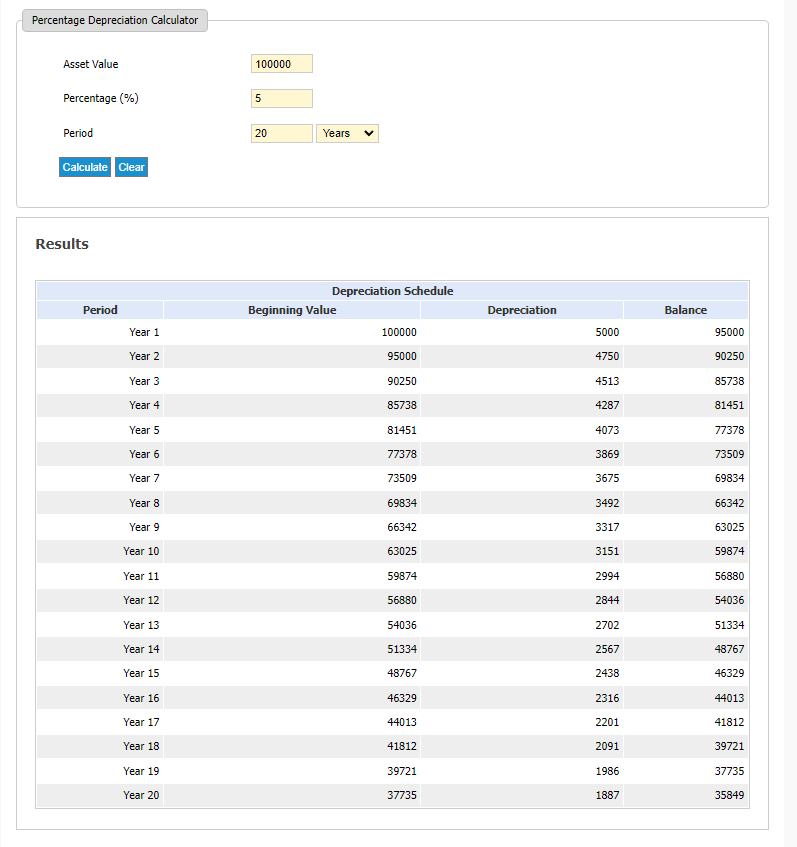